In [4]:
import os

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.morphology import label, binary_opening, disk

from sklearn.model_selection import train_test_split

import gc
import datetime


gc.enable()

import keras.backend as K

from keras.layers import *

from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [5]:
image_path = 'image_data/train_v2/'
test_image = 'image_data/test_v2/'

csv_dataset = 'csv_data/train_ship.csv'

exclude_list = ['6384c3e78.jpg', ]
original_img_size = (768, 768)

LR = 0.0001

BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 1500
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = True

weight_path="{}_weights.hdf5".format('seg_model')

In [6]:
df = pd.read_csv(csv_dataset)

df = df[~df['ImageId'].isin(exclude_list)]
df['ships'] = df.groupby(['ImageId'])['ImageId'].transform('count')
df.loc[df['EncodedPixels'].isnull().values,'ships'] = 0

df['file_size_kb'] = df['ImageId'].map(lambda image: 
                                       os.stat(os.path.join(image_path, image)).st_size/1024)
df = df[df['file_size_kb'] > 60]

In [7]:
imgs_w_ships = df[df['ships'] > 0]
imgs_wo_ships = df[df['ships'] == 0].sample(20000, random_state=6978)

selected_imgs = pd.concat((imgs_w_ships, imgs_wo_ships))

selected_imgs['has_ship'] = selected_imgs['ships'] > 0

Text(0.5, 1.0, 'after proccessing')

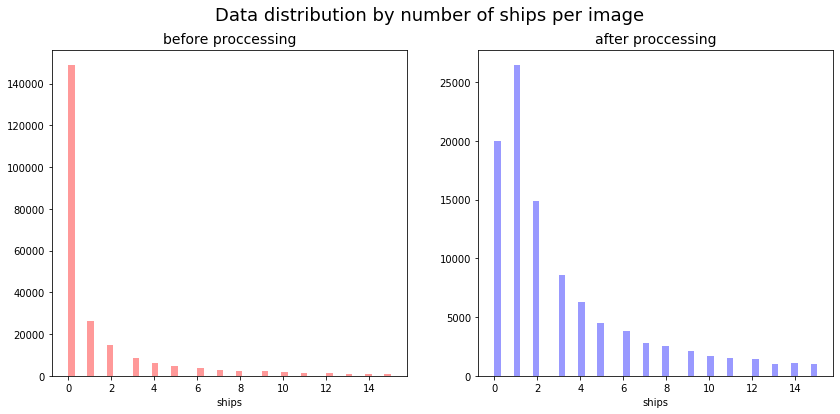

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

fig.suptitle('Data distribution by number of ships per image', fontsize=18)

sns.distplot(df['ships'], kde=False, color="r", ax=axes[0])
sns.distplot(selected_imgs['ships'], kde=False, color="b", ax=axes[1])

axes[0].set_title('before proccessing', fontsize=14)
axes[1].set_title('after proccessing', fontsize=14)

In [9]:
train_imgs, val_imgs = train_test_split(selected_imgs,
                                        test_size=0.10,
                                        stratify=selected_imgs['has_ship'],
                                        random_state=69278)

In [10]:
train_fnames = np.unique(train_imgs['ImageId'].values)
val_fnames = np.unique(val_imgs['ImageId'].values)

In [11]:
_, train_fnames = train_test_split(train_fnames, test_size=0.45, random_state=6978)
_, val_fnames = train_test_split(val_fnames, test_size=0.45, random_state=6978)

In [12]:
reduced_df = selected_imgs[['ImageId', 'EncodedPixels']]

train_df = reduced_df[reduced_df['ImageId'].isin(train_fnames)]
val_df = reduced_df[reduced_df['ImageId'].isin(val_fnames)]

In [13]:
def rle_encoder(img, min_max_threshold=1e-3, max_mean_threshold=None):
    """
    function for encoding image to submission dataset
    """
    if np.max(img) < min_max_threshold:
        return ''
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return ''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decoder(mask_rle, shape=(768, 768)):
    """
    function for decoding target image
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks2image(in_mask_list):
    """
    function for creating multi-layers mask
    that consist some ships on ine image
    """
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decoder(mask)
    return all_masks

# def masks2color(in_mask_list):
#     """
#     function for creating multi-layers mask with different color map
#     """
#     all_masks = np.zeros((768, 768), dtype = np.float)
#     scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
#     for i,mask in enumerate(in_mask_list):
#         if isinstance(mask, str):
#             all_masks[:,:] += scale(i) * rle_decoder(mask)
#     return all_masks

In [14]:
class CustomDataGenerator:
    
    def __init__(self, df_x, df_y,
                 valid_df=None,
                 batch_size=16,
                 image_path=None,
                 mask2image=None,
                 augmentator=None):
        
        self.df_x = df_x # list of image filenames which will use for training
        self.df_y = df_y # dataframe of image filenames and their encoded masks
        self.valid_df = valid_df # dataframe of images and their masks
        self.batch_size = batch_size # number of samples for one step
        self.image_path = image_path # path to train images
        self.augmentator = augmentator # image augmentation operations
        
    def __len__(self):
        return int(np.ceil(len(self.df_x) / float(self.batch_size)))
    
    def batch_creator(self, batch_fname, batch_df):
        height, width = original_img_size # take height and width for shape of input
        input_images = np.zeros((self.batch_size, height, width, 3))
        target_images = np.zeros((self.batch_size, height, width, 1))
        for i, img_name in enumerate(batch_fname):
            input_images[i, ...] = imread(os.path.join(image_path, img_name))
            rle = batch_df[batch_df['ImageId'] == img_name]['EncodedPixels'].values
            target_images[i, ...] = np.expand_dims(masks2image(rle), axis = 2)
        return (input_images, target_images)
    
    def generate(self):
        np.random.shuffle(self.df_x)
        num_of_batches = self.__len__()
        for batch in range(num_of_batches):
            batch_fname = np.random.choice(self.df_x, self.batch_size)
#             print(batch_fname)
            batch_df = self.df_y[self.df_y['ImageId'].isin(batch_fname)]
            yield self.batch_creator(batch_fname, batch_df)

In [15]:
train_gen = CustomDataGenerator(train_fnames, train_df, image_path=image_path, batch_size=BATCH_SIZE)
val_gen = CustomDataGenerator(val_fnames, val_df, image_path=image_path, batch_size=64)

In [16]:
t_gen = train_gen.generate()
v_gen = val_gen.generate()

In [17]:
dg_args = dict(featurewise_center = False, 
               samplewise_center = False,
               rotation_range = 45, 
               width_shift_range = 0.1, 
               height_shift_range = 0.1, 
               shear_range = 0.01,
               zoom_range = [0.5, 0.8],  
               horizontal_flip = True, 
               vertical_flip = True,
               fill_mode = 'nearest',
               data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args['brightness_range'] = [0.5, 1]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
    
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        gc.collect()

        yield next(g_x)/255.0, next(g_y)

In [18]:
# def IoU(y_true, y_pred, eps=1e-6):
#     if np.max(y_true) == 0.0:
#         return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
#     intersection = K.sum(y_true * y_pred, axis=[1,2,3])
#     union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
#     return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [19]:
checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      verbose=2,
                      patience=20)

callbacks_list = [checkpoint, reduceLROnPlat, early]

In [20]:
model = load_model('U-Net.h5')

/home/yura/anaconda3/envs/machine/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [24]:
def dice_score(y_pred, y_target):
    comm = K.sum(y_pred * y_target)
    return (comm * 2.0)/(K.sum(y_pred) + K.sum(y_target))

def dice_loss(y_pred, y_target):
    return 1-dice_score(y_pred, y_target)

In [25]:
def fit():
    model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=dice_loss, metrics=['binary_accuracy'])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(t_gen)
    loss_history = [model.fit_generator(aug_gen,
                                        steps_per_epoch=step_count,
                                        epochs=MAX_TRAIN_EPOCHS,
                                        validation_data=v_gen,
                                        validation_steps = 10,
                                        callbacks=callbacks_list,
                                        workers=1
                                        )]
    return loss_history

In [ ]:
while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.2:
        break

Epoch 1/99


In [108]:
inputs = Input(shape=(768,768,3))
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv0 = BatchNormalization()(conv0)
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
conv0 = BatchNormalization()(conv0)

comp0 = AveragePooling2D((6,6))(conv0)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)

pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)

pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)

pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.4)(conv4)

pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

upcv6 = UpSampling2D(size=(2,2))(conv5)
upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
upcv6 = BatchNormalization()(upcv6)
mrge6 = concatenate([conv4, upcv6], axis=3)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upcv7 = UpSampling2D(size=(2,2))(conv6)
upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
upcv7 = BatchNormalization()(upcv7)
mrge7 = concatenate([conv3, upcv7], axis=3)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upcv8 = UpSampling2D(size=(2,2))(conv7)
upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
upcv8 = BatchNormalization()(upcv8)
mrge8 = concatenate([conv2, upcv8], axis=3)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upcv9 = UpSampling2D(size=(2,2))(conv8)
upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
upcv9 = BatchNormalization()(upcv9)
mrge9 = concatenate([conv1, upcv9], axis=3)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

dcmp10 = UpSampling2D((6,6), interpolation='bilinear')(conv9)
mrge10 = concatenate([dcmp10, conv0], axis=3)
conv10 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
conv10 = BatchNormalization()(conv10)
conv10 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
conv10 = BatchNormalization()(conv10)
conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)

model = Model(inputs=inputs, outputs=conv11)